#**Modelo de Regressão Linear Múltipla**
Sua tarefa é **prever os valores médios** das casas nos distritos da Califórnia 🏡, considerando uma série de características desses distritos.

Vamos lá? 😀

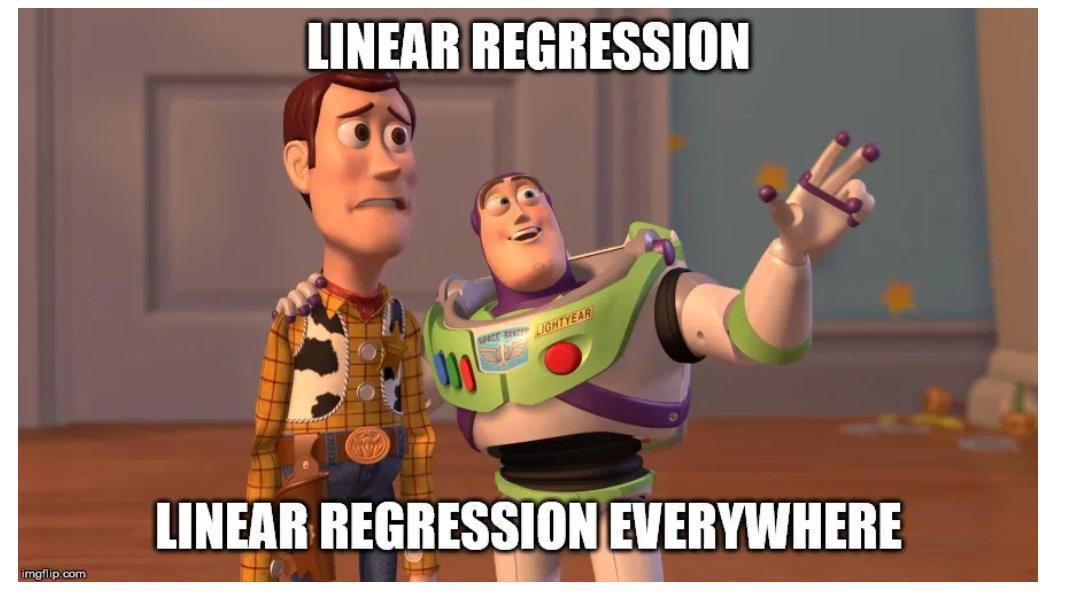

# Importando os dados

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("housing.csv")

In [3]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Configurações

Primeiro, vamos garantir que este notebook funcione bem em python 2 e 3, importar alguns módulos comuns, garantir que o MatplotLib plote figuras em linha.

In [4]:
# para deixar todas as saídas com os mesmos valores obtidos na live.
import numpy as np
np.random.seed(42)
import os

# Para plots bonitinhos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Conhecendo os dados 🤓

In [5]:
dataset.shape

(20640, 10)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Opa! Observe aqui que **total_bedrooms** possui **20433** linhas de informações preenchidas (não nulos). Isso significa que **207** bairros não possuem características.🤔

A única variável do tipo texto é "ocean_proximity". Vamos analisar quantas categorias existem e quantos bairros pertencem a essas categorias utilizando a função value_counts()?

In [7]:
set(dataset["ocean_proximity"])

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [8]:
dataset["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Agora vamos analisar os dados do tipo numérico com a função describe():

In [9]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Analisando algumas distribuições com histogramas:

array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

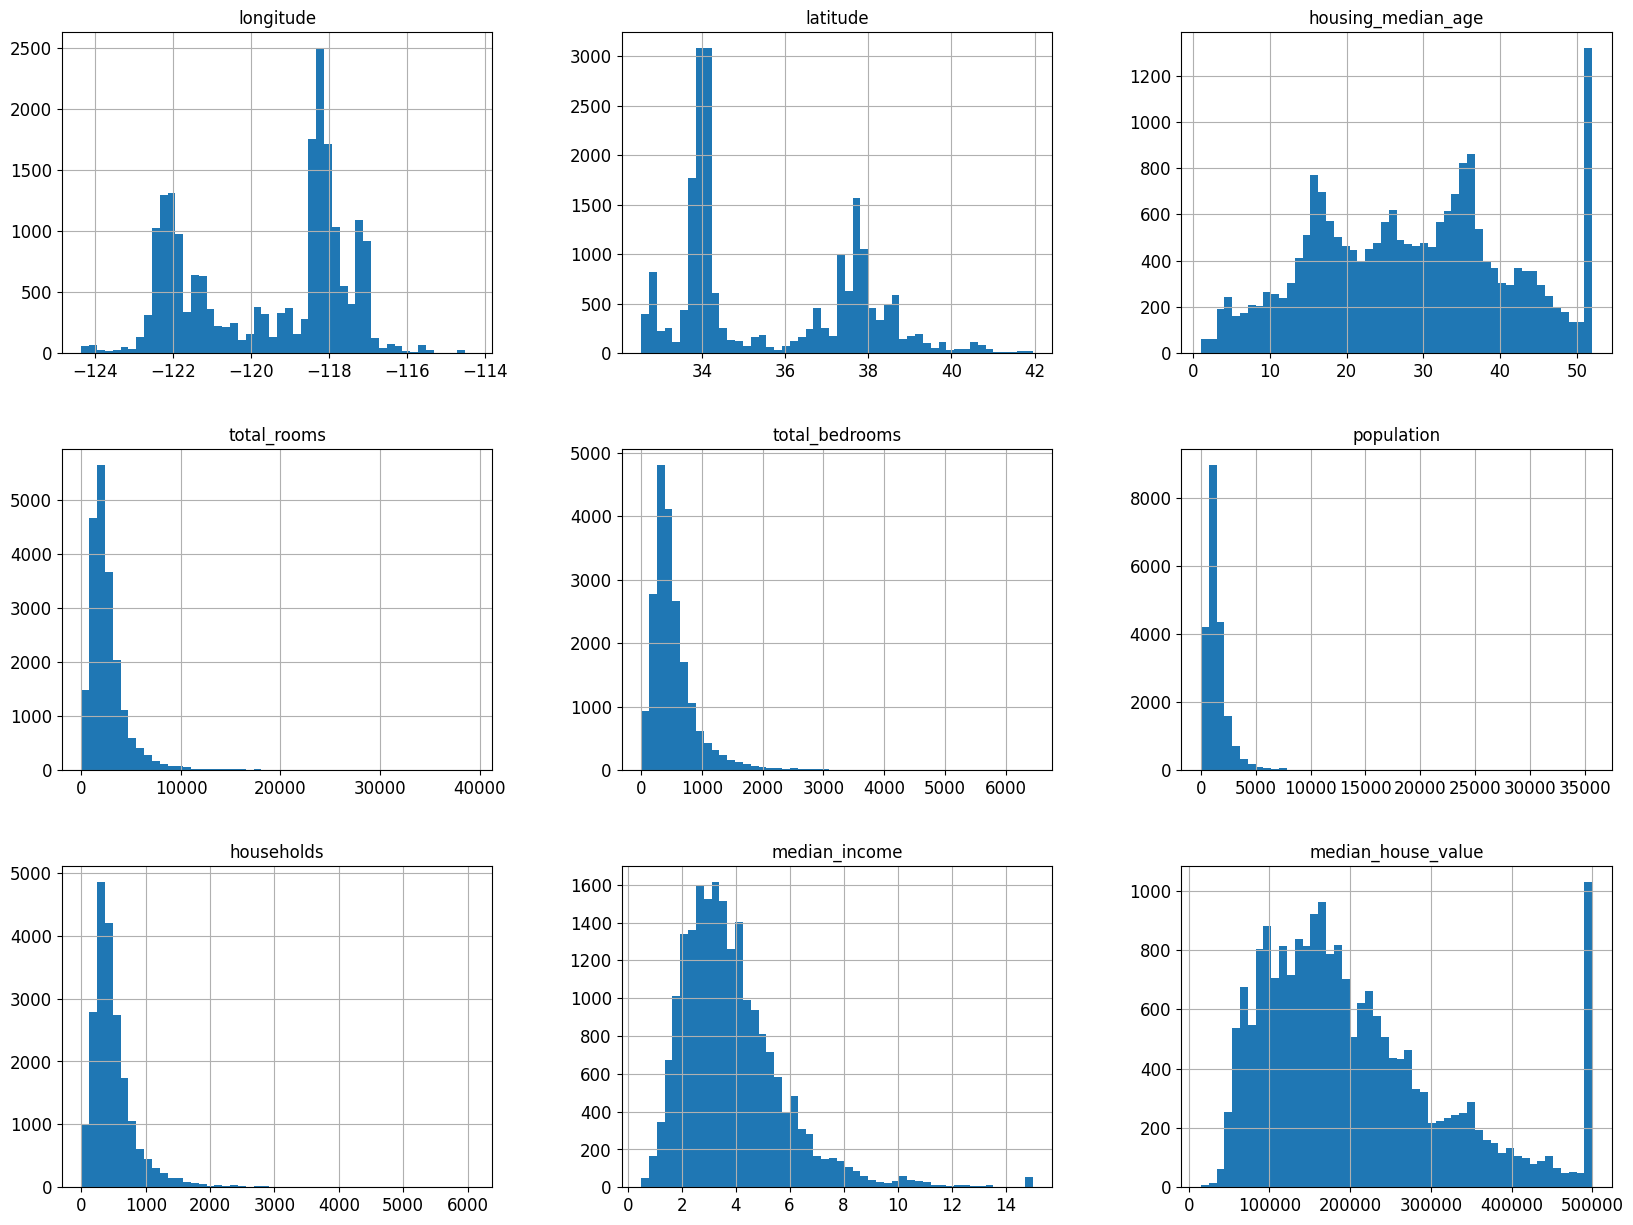

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))

Observações encontradas:

- median_income (renda média) não parece estar expresso em dólares americanos, dê uma olhadinha na escala dos dados. Aqui precisamos falar de dados dimensionados!

- a variável median_house_value (nossa target) também parece estar limitada em casas até 500 mil dólares. Aqui seria interessante entender com o cliente se o mesmo deseja que o algoritmo ultrapasse esse limite ou não.

- podemos identificar bastante assimetria nos dados.

# Separando as bases em treino e teste

In [11]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(dataset, test_size = 0.2, random_state = 7)

In [12]:
print(len(df_train), "treinamento +", len(df_test), "teste")

16512 treinamento + 4128 teste


## Criando categorias de média de renda anual 🤑

Vamos supor que algum especialista da área de vendas de imóveis notificou que a **média de renda anual é um atributo importante para colocar no modelo preditivo para estimar preços médios**.

Quando dividimos o conjunto de treino e teste **precisamos garantir que ambos sejam representativos com todos os valores de renda anual**.Como a média de renda anual é um atributo numérico, que tal criar uma categoria de renda ?

<Axes: >

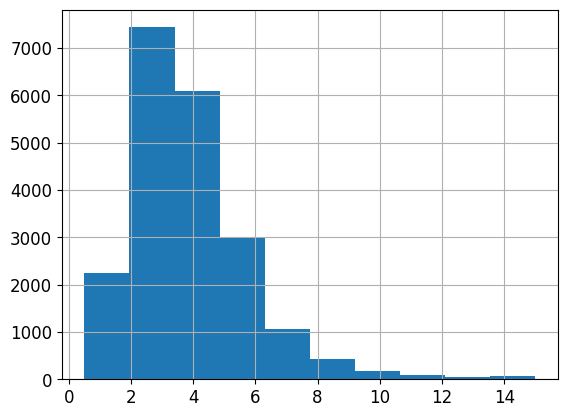

In [13]:
dataset["median_income"].hist()

In [14]:
# Divida por 1,5 para limitar o número de categorias de renda
# dividindo o valor da coluna "median_income" de cada entrada pelo valor 1,5 e, em seguida, arredondando o resultado para cima usando a função
# np.ceil() (da biblioteca NumPy). Isso cria uma nova coluna chamada "income_cat" no dataset que contém os valores das categorias de renda após
# a divisão e arredondamento.

dataset["income_cat"] = np.ceil(dataset["median_income"] / 1.5) # ceil para arredondar valores para cima

# Rotule aqueles acima de 5 como 5.
# os valores na coluna "income_cat" que forem maiores ou iguais a 5 são substituídos por 5. Isso é feito usando a função .where() do pandas.
# Basicamente, se o valor em "income_cat" for menor que 5, ele permanece o mesmo; caso contrário, é substituído por 5.

dataset["income_cat"].where(dataset["income_cat"] < 5, 5.0, inplace=True)

In [15]:
#cut do Pandas, que é comumente usada para dividir um conjunto de dados em intervalos discretos chamados de "bins" (intervalos ou faixas)
dataset["income_cat"] = pd.cut(dataset["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [16]:
dataset["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<Axes: >

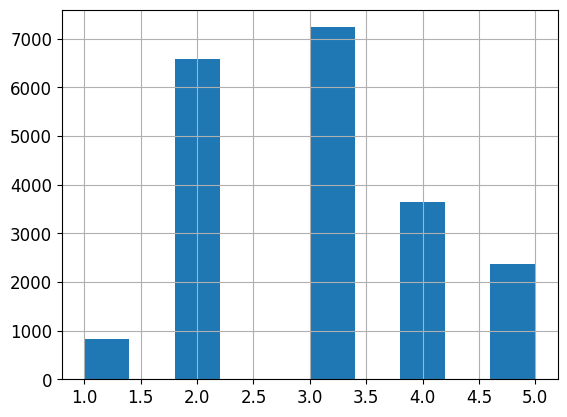

In [17]:
dataset["income_cat"].hist()

Resumindo, esse código está transformando valores contínuos de renda em categorias discretas, dividindo-os em intervalos específicos e arredondando-os para cima, garantindo que o número de categorias seja limitado e, finalmente, atribuindo rótulos numéricos a essas categorias.

Boa! Agora com as categorias criadas, vamos realizar a amostragem estratificada com base na categoria de renda!

In [18]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset, dataset["income_cat"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

In [19]:
# Analisando as proporções
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [20]:
# Analisando as proporções
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [21]:
dataset["income_cat"].value_counts() / len(dataset)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Show! Depois de garantir que os valores médios de renda anual estão distribuídos de forma estratificada, podemos remover a coluna income_cat que utilizamos como variável auxiliar.

In [22]:
# Removendo o income_cat das bases de treino e teste
# O uso do termo set_ é uma convenção para indicar que é uma variável temporária que itera sobre um conjunto de dados (um conjunto de treinamento ou um conjunto de teste).

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Analisando dados geográficos 🗾

In [23]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

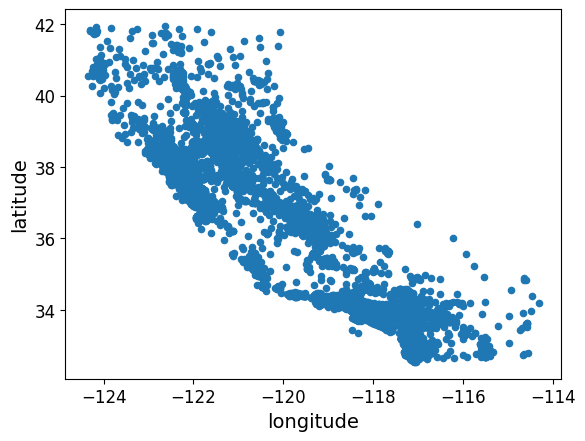

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude")

OK! Nos parece o estado da Caifornia 🏖 Vamos visualizar as concentrações de pontos?

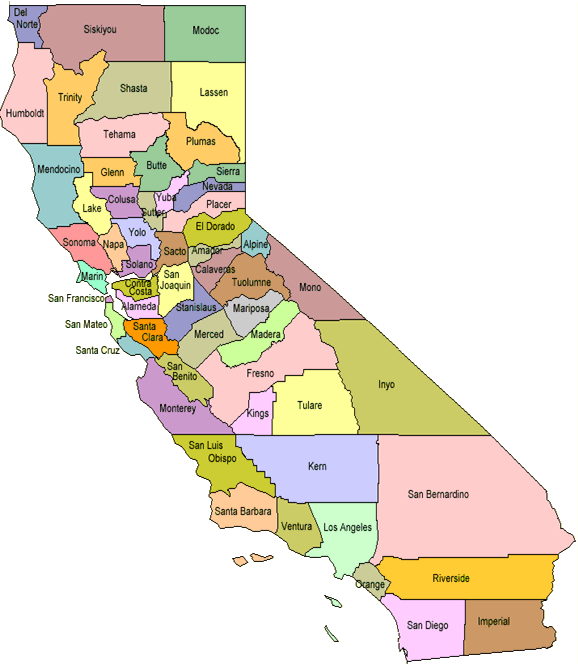

<Axes: xlabel='longitude', ylabel='latitude'>

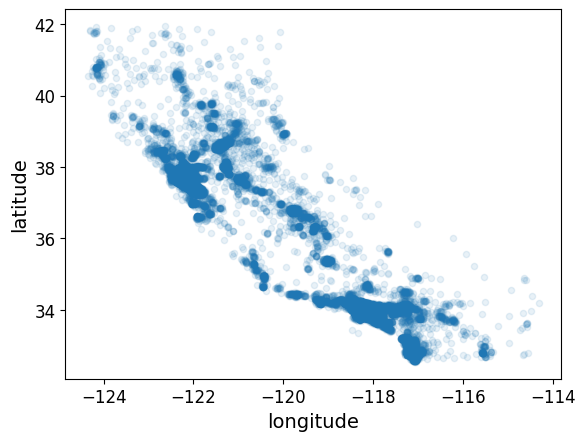

In [25]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

# Analisando preços imobiliários 🏠💰

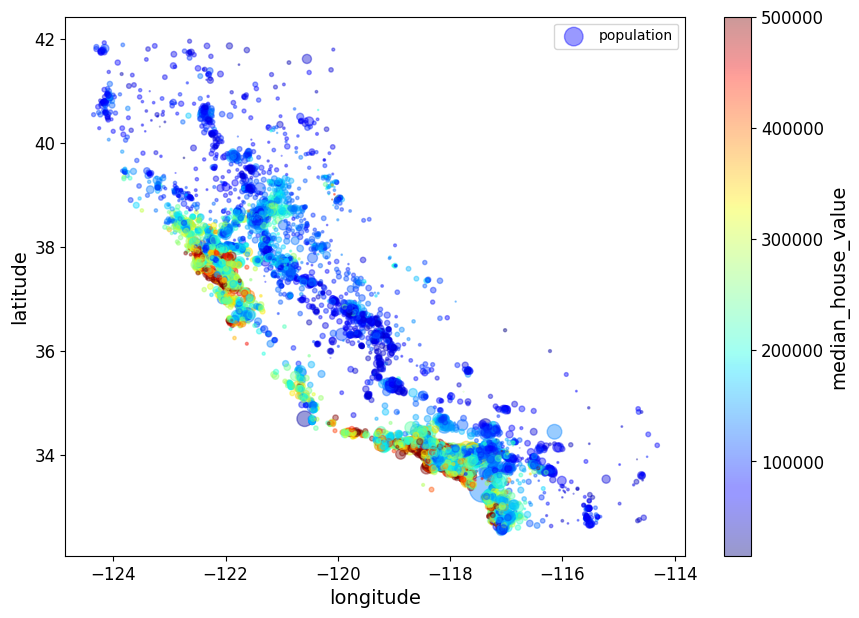

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Podemos identificar que os preços estão muito relacionados com a localização (por exemplo, próximo do oceano) e com a densidade populacional.

# Buscando correlações 🔎

In [27]:
corr_matrix = housing.corr()

<ipython-input-27-bac487469033>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [28]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='housing_median_age', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='housing_median_age', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='housing_median_age', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='housing_median_age'>,
        <Axes: xlabel='median_income', ylabel='housing_median_age'>,
        <Axes: xlabel='total_rooms', ylabel='housi

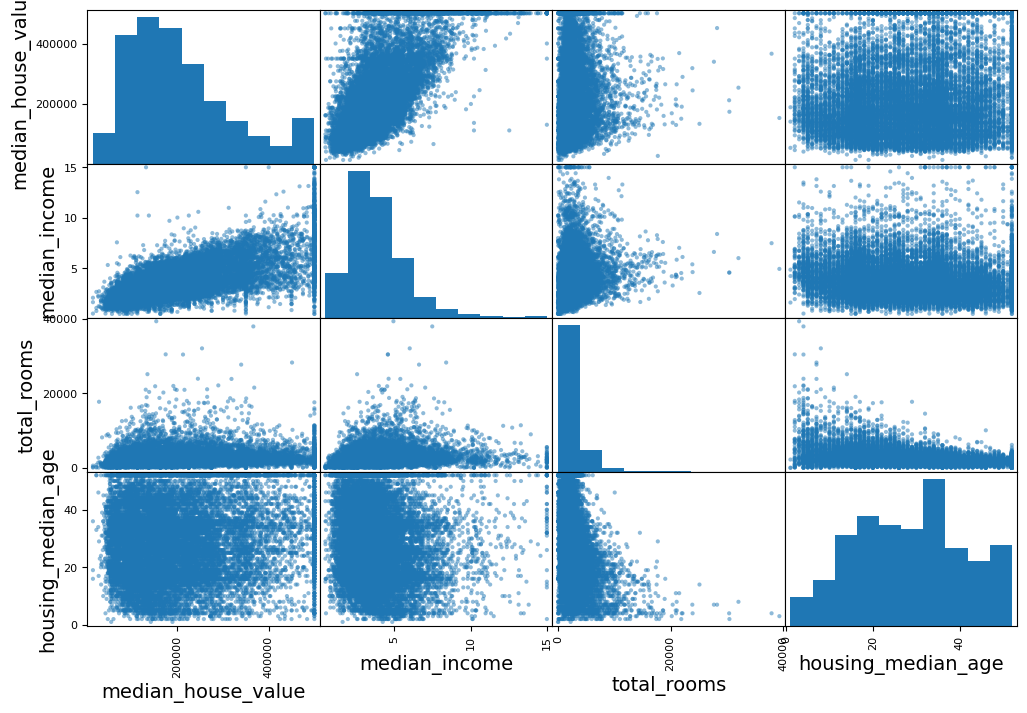

In [29]:
# from pandas.tools.plotting import scatter_matrix
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

Analisando as correlações, a feature que seja mais promissora para prever o valor médio da habitação é a **renda média**.

median_income : 0.68 de correlação.

Vamos plotar essas duas features em um gráfico de scatter para analisar com mais detalhes:

(0.0, 16.0, 0.0, 550000.0)

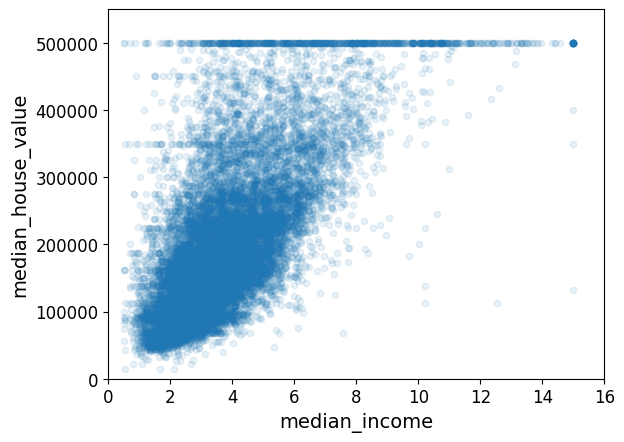

In [30]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])

Observamos que:
A correlação realmente mostra uma certa tendência ascendente nos dados e os pontos não estão mais dispersos.

O limite de preço que temos na base de dados é claramente visível como uma linha horizontal em 500 mil dólares. Observe também que temos essas linhas retas (claro que menos óbvias) na horizontal em torno de 450 mil dólares, outra em 350 mil dólares e uma em 280 mil dólares.

Será que se deixarmos essas peculiaridades nos dados, não pode afetar nosso algoritmo? ❓🤔


# Preparando os dados para colocar no algoritmo 🧰

In [31]:
housing = strat_train_set.drop("median_house_value", axis=1) # apagando a target para a base de treino (nosso x)
housing_labels = strat_train_set["median_house_value"].copy() #armazenando a target (nosso y)

In [32]:
# listando as colunas nulas

sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [33]:
housing.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

OK, como vamos tratar esses valores nulos? ❓🤔

In [34]:
#Opção 1
# Substituindo os valores nulos pela mediana
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


# Utilizando as classes do Sklearn!

Você também pode optar por utilizar classes acessíveis do Sklearn!

Você pode criar pipelines de pré-processamento e modelagem com facilidade usando as classes do Scikit-Learn. Isso permite criar fluxos de trabalho mais organizados e repetíveis.

Vamos utilizar o **Imputer** para substituir os valores faltantes pela média.

In [35]:
# Opção 2
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

imputer = SimpleImputer(strategy="median")

Remova o atributo de texto porque a mediana só pode ser calculada em atributos numéricos:

In [36]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [37]:
imputer.fit(housing_num) # calculando a mediana de cada atributo e armazenando o resultado na variável statistics_

SimpleImputer(strategy='median')

In [38]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Verifique se isso é o mesmo que calcular manualmente a mediana de cada atributo:

In [39]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Aplicando o Imputer "treinado" na base para substituir valores faltantes perdidos pela mediana:

In [40]:
X = imputer.transform(housing_num) # o resultado é um array.

In [41]:
X

array([[-1.2146e+02,  3.8520e+01,  2.9000e+01, ...,  2.2370e+03,
         7.0600e+02,  2.1736e+00],
       [-1.1723e+02,  3.3090e+01,  7.0000e+00, ...,  2.0150e+03,
         7.6800e+02,  6.3373e+00],
       [-1.1904e+02,  3.5370e+01,  4.4000e+01, ...,  6.6700e+02,
         3.0000e+02,  2.8750e+00],
       ...,
       [-1.2272e+02,  3.8440e+01,  4.8000e+01, ...,  4.5800e+02,
         1.7200e+02,  3.1797e+00],
       [-1.2270e+02,  3.8310e+01,  1.4000e+01, ...,  1.2080e+03,
         5.0100e+02,  4.1964e+00],
       [-1.2214e+02,  3.9970e+01,  2.7000e+01, ...,  6.2500e+02,
         1.9700e+02,  3.1319e+00]])

In [42]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [43]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [44]:
# verificando os resultados
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


In [45]:
imputer.strategy

'median'

In [46]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


# Pré-processando as categorias

Agora vamos pré-processar o recurso de entrada categórica, `ocean_proximity`:

In [47]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


O **OrdinalEncoder** é uma classe da biblioteca scikit-learn, usada para transformar variáveis categóricas ordinais em valores numéricos. Variáveis ordinais são aquelas que têm uma ordem ou hierarquia específica, mas as distâncias entre os valores não são necessariamente significativas.

In [48]:
try:
    from sklearn.preprocessing import OrdinalEncoder
except ImportError:
    from future_encoders import OrdinalEncoder # Scikit-Learn < 0.20

In [49]:
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [50]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

O **OneHotEncoder** é outra classe da biblioteca scikit-learn, usada para transformar variáveis categóricas em representações numéricas binárias. Ele é particularmente útil quando se lida com variáveis categóricas nominais, ou seja, aquelas que não têm uma ordem específica.

In [51]:
try:
    from sklearn.preprocessing import OrdinalEncoder # apenas para gerar um ImportError se Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [52]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

# Criando a pipeline de pré-processamento dos dados 🔧

Agora vamos construir um pipeline para pré-processar os atributos numéricos:

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), #substituindo valores nulos pela mediana
        ('std_scaler', StandardScaler()), # padronizando as escalas dos dados
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [54]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.73260236,
         0.55628602, -0.8936472 ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.53361152,
         0.72131799,  1.292168  ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.67467519,
        -0.52440722, -0.52543365],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.86201341,
        -0.86511838, -0.36547546],
       [-1.56080303,  1.2492109 , -1.1653327 , ..., -0.18974707,
         0.01061579,  0.16826095],
       [-1.28105026,  2.02567448, -0.13148926, ..., -0.71232211,
        -0.79857323, -0.390569  ]])

Agora, vamos tratar os valores categóricos:

O **ColumnTransformer** é uma classe da biblioteca scikit-learn em Python que permite aplicar transformações específicas a diferentes colunas de um conjunto de dados (dados numéricos, categóricos, etc.) e deseja aplicar diferentes pré-processamentos ou transformações a cada tipo de coluna.

In [55]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

In [56]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), #tratando as variáveis numéricas (chamando a pipeline de cima)
        ("cat", OneHotEncoder(), cat_attribs), # tratando as variáveis categóricas
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [57]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [58]:
housing_prepared.shape

(16512, 13)

In [59]:
type(housing_prepared)

numpy.ndarray

Perceba que o resultado é uma matriz multidimensional. Precisamos transformá-la em dataframe.

In [60]:
column_names = [
    'longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms',
    'population', 'households', 'median_income', '<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

# Transformar o array em DataFrame
housing_df = pd.DataFrame(data=housing_prepared, columns=column_names)

# Exibir o DataFrame resultante
print(housing_df.shape)

(16512, 13)


In [61]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-0.941350,1.347438,0.027564,0.584777,0.640371,0.732602,0.556286,-0.893647,0.0,1.0,0.0,0.0,0.0
1,1.171782,-1.192440,-1.722018,1.261467,0.781561,0.533612,0.721318,1.292168,0.0,0.0,0.0,0.0,1.0
2,0.267581,-0.125972,1.220460,-0.469773,-0.545138,-0.674675,-0.524407,-0.525434,0.0,1.0,0.0,0.0,0.0
3,1.221738,-1.351474,-0.370069,-0.348652,-0.036367,-0.467617,-0.037297,-0.865929,0.0,0.0,0.0,0.0,1.0
4,0.437431,-0.635818,-0.131489,0.427179,0.272790,0.374060,0.220898,0.325752,1.0,0.0,0.0,0.0,0.0


In [62]:
print(housing_df.isnull().sum())

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
<1H OCEAN             0
INLAND                0
ISLAND                0
NEAR BAY              0
NEAR OCEAN            0
dtype: int64


Prontinho! Nossos dados estão limpinhos e organizados 🌟

# Escolhendo o melhor modelo de regressão 📈

Vamos começar com a velha e boa regressão linear!

- Equação do 1° grau.

- A Regressão Linear busca entender o padrão de um valor dependendo de outro ou outros, e assim encontrar uma função que expressa esse padrão.

- **Foco**: buscar o melhor valor que os coeficientes possam atingir, de maneira que a diferença entre o valor predito pela função e o real, sejam os menores.





In [63]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [64]:
# vamos tentar o pipeline de pré-processamento completo em algumas instâncias de treinamento
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

predictions = lin_reg.predict(housing_prepared)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841]


Compare com os valores reais:

In [65]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


# Avaliando o modelo ✅

O **MSE** mede a média dos quadrados das diferenças entre os valores previstos pelo modelo e os valores reais observados no conjunto de dados.

Quanto menor o valor do MSE, melhor o ajuste do modelo aos dados.

In [66]:
from sklearn.metrics import mean_squared_error
# erro médio quadrático eleva ao quadrado a média do erro médio absoluto. Estou avaliando se os erros não são tão grandes, esses erros são penalizados.
# penaliza muito mais valores distantes da média.

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse) # raiz quadrada aqui
lin_rmse

69050.56219504567

In [67]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49905.329442715316

Um erro de margem de 69050 dólares não é muito aceitável no nosso modelo sendo que os valores de median_housing_values variam entre  120 mil dólares e 265 mil dólares 😞 Podemos definir aqui que esse modelo está com overfiting.
Vamos tentar um modelo mais poderoso?

In [68]:
from sklearn.metrics import r2_score

In [69]:
r2 = r2_score(housing_labels, housing_predictions)
print('r²',r2)

r² 0.6438078994746375


In [70]:
# Função para calcular o MAPE (Mean Absolute Percentage Error)

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [71]:
# Calcular o MAPE
mape_result = calculate_mape(housing_labels, housing_predictions)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")

O MAPE é: 28.65%


# Que tal tentar outros models? 🌲

In [72]:
from sklearn.tree import DecisionTreeRegressor

# Criando o modelo de DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(max_depth=10)
model_dtr.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(max_depth=10)

In [73]:
# vamos tentar o pipeline de pré-processamento completo em algumas instâncias de treinamento
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
predictions = model_dtr.predict(some_data_prepared)

print("Predictions:", model_dtr.predict(some_data_prepared))

Predictions: [ 90980.88235294 324661.11111111  72856.96202532 168772.60273973
 226591.38505747]


In [74]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [75]:
# mean_squared_error
housing_predictions = model_dtr.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

47873.314559945495

In [76]:
# mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

32067.265630356796

In [77]:
r2 = r2_score(housing_labels, housing_predictions)
print('r²',r2)

r² 0.8287869591640339


In [78]:
# Calcular o MAPE
mape_result = calculate_mape(housing_labels, housing_predictions)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")

O MAPE é: 17.94%
